# MC-matching based on minimum angle between genParticle and pfcharged, used to determine momentum resolution

In this example, `ak.cartesian()` is used to make pairs of MC-truth generated particles (from `Particles`) and reconstructed hadrons (from `ReconstructedParticles`). The cosine of the angle between the generated and reco particles is calculated, and used as a metric for picking the best pair. The generated information is then associated to the reco information for each reco hadron, allowing quantities like $\delta(p)$ to be calculated. 

The code is based on the example found in [this](https://github.com/jpivarski-talks/2020-04-08-eic-jlab/blob/master/2020-04-08-eic-jlab-EVALUATED.ipynb) `awkward array` tutorial, where brem photons are associated to electrons. 

In [32]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file = uproot.open("/eos/experiment/fcc/ee/tmp/test.root")
tree = file['events']

Get the reconstructed stable hadrons:

In [33]:
#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
h_container = "ReconstructedParticles"
h_c = f'{h_container}/{h_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and h_c in v):
        keep_vars.append(v)

h = tree.arrays(keep_vars,how="zip")
h[h_c,'p'] = kinematics.calc_p(h,h_c)
h_pi_cut = abs(h[h_c,'mass'] - lp.pi_plus.mass/1000.) < 1e-4
h_k_cut = abs(h[h_c,'mass'] - lp.K_plus.mass/1000.) < 1e-4
h = h[np.logical_or(h_pi_cut,h_k_cut)]

Get the generated particles:

In [34]:
g_c = "Particle"
g = tree.arrays(filter_name=f"{g_c}*",how="zip")
g[g_c,'p'] = kinematics.calc_p(g,g_c)
g_pi_cut = abs(g[g_c,"PDG"]) == abs(lp.pi_plus.pdgid)
g_k_cut = abs(g[g_c,"PDG"]) == abs(lp.K_plus.pdgid)
g = g[g_c][np.logical_or(g_pi_cut,g_k_cut)]

Make pairs of reco and gen particles across all events:

In [35]:
pairs = ak.cartesian({"reco": h[h_c], "gen": g}, nested=True)

Calculate $\cos(\theta)$ between the reco and true particles, which we will use as a matching requirement:

In [36]:
pairs["costheta"] = kinematics.cos_angle(pairs["reco"], pairs["gen"])

Pick best pair according to $\cos(\theta)_{max}$ i.e. minimum angle:

In [37]:
best_pair = pairs[ak.singletons(ak.argmax(pairs["costheta"], axis=2))]

Associate the best gen particle with the reco particle:

In [38]:
h["match"] = ak.firsts(best_pair, axis=2)

Can get the reco info using `h["match","reco","var_name"]` and the corresponding MC-truth value with `h["match","gen","var_name"]`. So can calculate a resolution like this:

In [39]:
h[h_c,"delta_p"] = h["match","reco","p"] - h["match","gen","p"]
h[h_c,"delta_p_per"] = 100*(h[h_c,"delta_p"] / h["match","gen","p"])

Remove some outliers to get a sensible measure of the width:

In [40]:
max_val = 0.6
h = h[abs(h[h_c,"delta_p_per"]) < max_val]
delta_p_mu = np.mean(ak.flatten(h[h_c,"delta_p_per"]))
print(f"Momentum resolution mu = {delta_p_mu:.4f}")
delta_p_sigma = np.std(ak.flatten(h[h_c,"delta_p_per"]))
print(f"Momentum resolution sigma = {delta_p_sigma:.4f}")

Momentum resolution mu = -0.0006
Momentum resolution sigma = 0.1484


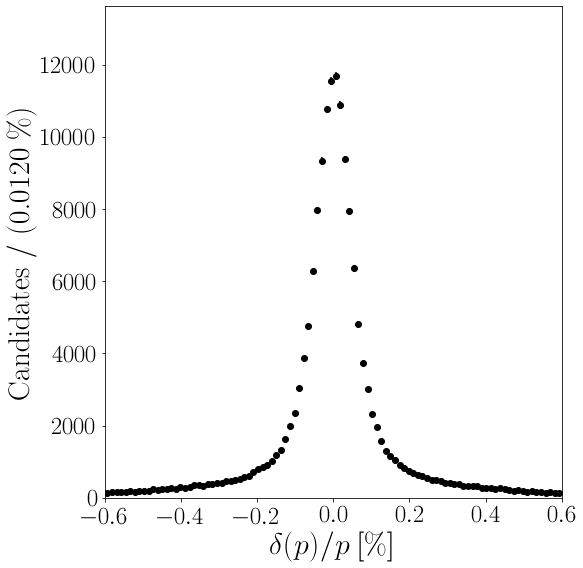

In [41]:
plotting.errorbar_hist(h[h_c],"delta_p_per","all_hadrons_angle_match","$\delta(p)/p$","$\%$",-max_val,max_val,100)

We can also look at the momentum resolution as a function of momentum, by splitting the sample into $p$ bins and plotting the average $\delta(p)/p$ in each bin. We make some bins, then calculate the bin centres and put them into `p_vals`. We then cut on the hadrons so that we keep only the ones in a certain bin using `h_bin_cut`, and then calculate the standard deviation of the $\delta(p)/p$ values in that bin. These are stored in `delta_p_per_vals`. We can then plot these values as a function of $p$.

In [42]:
n_bin_edges = 11
p_min = 0.5
p_max = 15.
bins = np.linspace(p_min, p_max, n_bin_edges)

delta_p_per_vals = []
p_vals = []
for i in range(0,len(bins)-1):
    p_vals.append(bins[i] + 0.5*(bins[i+1] - bins[i]))
    h_bin_cut = np.logical_and(h[h_c,'p'] >= bins[i], h[h_c,'p'] < bins[i+1])
    h_bin = h[h_bin_cut]
    delta_p_per_vals.append(np.std(ak.flatten(h_bin[h_c,"delta_p_per"])))

Now to plot the momentum resolution as a function of momentum

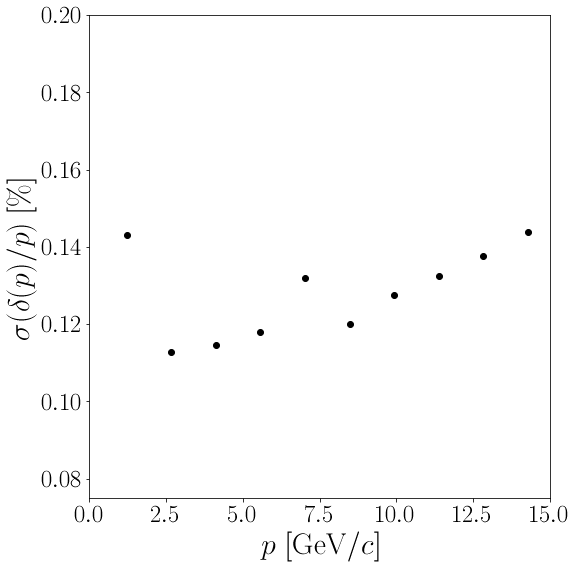

In [43]:
plotting.errorbar_plot(p_vals, 
                       delta_p_per_vals, 
                       "p", 
                       "delta_p_per", 
                       "$p$ [GeV/$c$]", 
                       "$\sigma(\delta(p)/p)$ [$\%$]", 
                       [0.,p_max], 
                       [0.075,0.2], 
                       x_err=None, 
                       y_err=None)